**извлечение признаков из текста на естественном языке**

кластеризатор текстов   
   лемматизация + CountVectorizer + KMeans

Евгений Борисов borisov.e@solarl.ru

## библиотеки

In [1]:
import re
# import gzip
import numpy as np
import numpy.random as rng
import pandas as pd
from tqdm import tqdm

np.set_printoptions(precision=2) # вывод на печать чисел до 2 знака
pd.options.display.max_colwidth = 200 

tqdm.pandas()

In [2]:
from sklearn import __version__ as SKLEARN_VERSION

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt

from pymorphy2 import MorphAnalyzer

SKLEARN_VERSION

'0.24.1'

## тексты

In [3]:
# загружаем тексты
data = pd.read_pickle('../data/news.pkl.gz')
print('записей:',len(data))

записей: 3196


In [4]:
data.sample(2)

,text,tag
1251,"""Спасибо за идеи. Некоторые реализовали"". Начальник УГАИ — о письмах от водителей и пешеходов\n\n30 ноября 2016 в 10:45\n\nТатьяна Матвеева / TUT.BY\n\nГосавтоинспекция региона проводит проект «От...",auto
696,"Жительница Постав зарабатывала сутенерством, использовав в том числе 12-летнюю девочку\n\n9 декабря 2016 в 15:59\n\nTUT.BY\n\nЗавершено расследование уголовного дела в отношении 48-летней жительни...",incident


## токенизация и очистка

In [5]:
# собираем словарь из текстов
def get_vocabulary(ds):
    vcb = [ set(s) for s in ds.tolist() ]
    return sorted(set.union(*vcb))

In [6]:
# лемматизация и очистка с помощью пакета морфологического анализа

morph = MorphAnalyzer()

# применяет список замен pat к строке s
def replace_patterns(s,pat):
    if len(pat)<1: return s
    return  replace_patterns( re.sub(pat[0][0],pat[0][1],s), pat[1:] )

# нормализация текста
def string_normalizer(s):
    pat = [
       [r'ё','е'] # замена ё для унификации
       ,[r'</?[a-z]+>',' '] # удаляем xml
       ,[r'[^a-zа-я\- ]+',' '] # оставляем только буквы, пробел и -
       ,[r' -\w+',' '] # удаляем '-й','-тый' и т.п.
       ,[r'\w+- ',' ']
       ,[r' +',' '] # удаляем повторы пробелов
    ]
    return replace_patterns(s.lower(),pat).strip()

# NOUN (существительное), VERB (глагол), ADJF (прилагательное)
def word_normalizer(w, pos_types=('NOUN','VERB','ADJF')):
    if not morph.word_is_known(w): return ''
    p = morph.parse(w)[0] 
    return p.normal_form if (p.tag.POS in pos_types) else ''


def tokenize_normalize(s):
    return [ word_normalizer(w) for w in s.split(' ') if len(w)>1 ]

In [7]:
data['ctext'] = data['text']\
                    .progress_apply(string_normalizer)\
                    .progress_apply(tokenize_normalize)

100%|██████████| 3196/3196 [01:20<00:00, 39.74it/s]


In [8]:
vcb0 =  get_vocabulary( data['ctext'] )
print('словарь %i слов'%(len(vcb0)))
# pd.DataFrame( vcb ).to_csv('voc0.txt',index=False,header=False)

словарь 22673 слов


In [9]:
data['ctext'] = data['ctext'].apply(' '.join)

In [10]:
data.sample(10)

,text,tag,ctext
377,"Франсуа Кеворкян вновь претендует на звание ""Лучшего резидента"" и едет\nв Москву Франсуа Кеворкян, как и в прошлом году, номинирован на премию\nClub World Awards. Конкуренцию в категории ""Лучший р...",culture,франсуа претендовать звание хороший резидент ехать москва франсуа прошлый год премия конкуренция категория хороший резидент составить итог объявить
1455,"Венесуэла закрывает границу с Колумбией из-за валютной мафии Код для вставки в блог Телеканал ""Звезда""Венесуэла закрывает границу с Колумбией из-за валютной мафии13 декабря 2016, 03:21Президент Ве...",politics,венесуэла закрывать граница колумбия валютный мафия код вставка блог телеканал звезда венесуэла закрывать граница колумбия валютный мафия декабрь президент венесуэла николас распорядиться гра...
1389,"13.12.16 10:00\n\nМосква. 13 декабря. ИНТЕРФАКС - Почти три четверти россиян уверены, что президент РФ Владимир Путин ""искренне хочет добиться повышения благосостояния населения"": 24% из них счита...",politics,москва декабрь интерфакс четверть россиянин президент рф владимир путин хотеть повышение благосостояние население считать удаться опасаться помешать бюрократия отсутствие хороший ком...
1657,"МОСКВА, 13 дек — РИА Новости. Российские власти предложили Темирлану Эскерханову, обвиняемому по уголовному делу об убийстве Бориса Немцова, компенсацию в шесть тысяч евро, пишет ""Коммерсант"". По ...",politics,москва дек риа новость российский власть предложить уголовный дело убийство борис немцов компенсация тысяча евро писать коммерсант данные газета аналогичный выплата мочь другой фигурант н...
2890,"Вчера, 20:30\n\nАвтостроительная компания из Южной Кореи Kia Motors во второй раз решила привлечь внимание к себе и опубликовала в Сети новый видеотизер. На этот раз на ролике демонстрируется нови...",auto,автостроительный компания южный корея второй раз решить внимание опубликовать сеть новый этот раз ролик демонстрироваться новинка который планировать серийный производство официальный...
1687,Самолет A380 немецкой авиакомпании Lufthansa совершил экстренную посадку в международном аэропорту имени Джона Кеннеди в Нью-Йорке после сообщения о заложенной на борту бомбе. Инцидент произошел в...,incident,самолёт немецкий авиакомпания совершить экстренный посадка международный аэропорт имя джон кеннеди нью-йорк сообщение борт бомба инцидент произойти понедельник декабрь местный время ранний ...
654,"Элитные подарки от фабрики ""ГеосИдеал""!\n\n5 декабря 2016 в 9:00\n\n*На правах рекламы\n\nВ предновогодней суете, придумывая и разыскивая подарки для самых близких людей, не забудьте про подарок и...",reclama,элитный подарок фабрика декабрь право реклама предновогодний суета подарок самый близкий человек забыть подарок подарок который мечтать целый год подарок который волшебный образ изменить...
1205,"Специалист о пробках на площади Богушевича: Пока мы строим метро, ситуация не изменится\n\n9 декабря 2016 в 13:05\n\nТамара Савич / AUTO.TUT.BY\n\nАвтомобилист Сергей из Минска пожаловался, что еж...",auto,специалист пробка площадь строить метро ситуация измениться декабрь тамара автомобилист сергей минск пожаловаться застревать пробка площадь выяснить специалист исправиться ситу...
2679,"Ученые из института исследований в области медицины в Барселоне сделали важное открытие, которое позволит в будущем эффективно бороться с онкологическими заболеваниями.\r\nДело в том, что специали...",science,учёный институт исследование область медицина барселона сделать важный открытие который позволить будущее онкологический заболевание дело тот специалист выяснить причина живучесть раковый клет...
441,"Горбачев: В развале СССР виновато прежнее руководство России\n\n7 декабря 2016 в 21:49\n\nРусская служба Би-би-си\n\nЭкс-президент СССР Михаил Горбачев считает, что в развале Советского Союза вино...",politics,горбачёв развал ссср прежний руководство россия декабрь русский служба би-би-си экс-президент ссср михаил горбачёв считать развал советский союз участник беловежск

##  Vectorizer

In [11]:
def tokenizer(s): 
    for w in s.split(' '):
        if (len(w)>1): 
            yield w

X = CountVectorizer(tokenizer=tokenizer, token_pattern=None).fit_transform(data['ctext'])

## кластеризируем

In [12]:
data['cluster'] = KMeans(n_clusters=12).fit(X).labels_
data['cluster'].drop_duplicates().count()

12

## тестируем

In [13]:
# номер кластера, количество объектов, метки объектов
# (cluster=-1 - некластеризованные DBSCAN объекты)
cluster_descr = pd.concat([
        data[['cluster','tag']].groupby(['cluster'])['tag'].count(),
        data[['cluster','tag']].groupby(['cluster'])['tag'].apply(lambda s: set(s)).apply(' '.join)
    ],axis=1).reset_index()

cluster_descr.columns = ['cluster','count','tags']

cluster_descr

,cluster,count,tags
0,0,59,culture tech sport
1,1,128,woman reclama culture social science politics auto sport economics realty tech incident
2,2,1,sport
3,3,1,incident
4,4,437,woman reclama culture social tech science politics realty economics sport auto incident
5,5,1,woman
6,6,1,woman
7,7,15,woman social sport realty economics auto
8,8,4,sport
9,9,1,woman


<AxesSubplot:xlabel='cluster'>

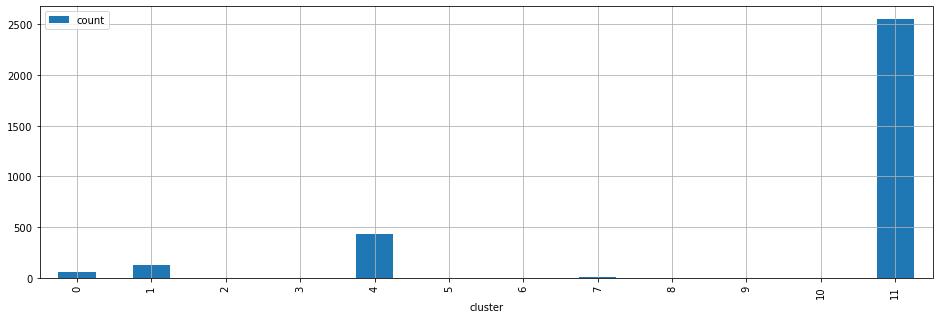

In [14]:
# размеры кластеров
cluster_descr[['cluster','count']]\
    .query('cluster>-1')\
    .set_index('cluster')\
    .plot.bar(grid=True,figsize=(16,5))

In [15]:
def print_cluster_samples(n,ns=3,nt=300):
    count,tags = cluster_descr.query(f'cluster=={n}')[['count','tags']].values[0]#.tolist
    df = data.query(f'cluster=={n}')
    ns_ = min(ns,len(df))
    top = [ t[:nt].replace('\n',' ') for t in df['text'].sample(ns_).values ]
    print('[ КЛАСТЕР %i, элементов: %i, метки: "%s" ]'%(n,count,tags))
    for s in top: print('\n%s ...\n'%(s) )

In [17]:
for n in rng.permutation(cluster_descr['cluster'].max())[:3] :
    print_cluster_samples(n)
    print('\n= = = = = = = = = = = = = = = = = = = = = = = = = =\n')

[ КЛАСТЕР 3, элементов: 1, метки: "incident" ]

Гомельские строители утверждают, что их "кинули" в Жлобине. Бизнесмен: "Это ложь и клевета"  9 декабря 2016 в 13:45  Елена Бычкова / TUT.BY  В редакцию TUT. BY обратились строители одной из гомельской фирм, которые утверждают — их «кинули». Не в России, а дома, на родине. Уже два года мужчины ищут с ...


= = = = = = = = = = = = = = = = = = = = = = = = = =

[ КЛАСТЕР 0, элементов: 59, метки: "culture tech sport" ]

«Индиана» — «Шарлотт» 110:94  «Индиана Пэйсерс» на домашнем паркете обыграла «Шарлотт Хорнетс» со счетом 110:94 (25:20, 20:23, 31:30, 34:21).  Наибольший вклад в успех хозяев внесли Пол Джордж и Майлз Тернер, набравшие по 22 очка.  В составе «Хорнетс» выделим Николя Батюма, оформившего дабл-дабл из  ...


"Действительно важное кино". В Минске покажут лучший европейский фильм года  7 декабря 2016 в 9:34  AFISHA.TUT.BY  В преддверии вручения европейского "Оскара" в «Falcon club Бутик кино» состоятся показы фильма «Тони Эрдманн» —